In [1]:
import pandas as pd
import networkx as nx

# --- 1. 读取 MR 数据 ---
df_xm = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/APOM_to_mediators.csv')      
# columns: protein, mediator, beta_XM
df_mo = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/mediators_to_outcomes.csv')     
# columns: mediator, outcome, beta_MO
# 可选直接路径
try:
    df_xo = pd.read_csv('protein_to_outcomes.csv')  
    has_direct = True
except FileNotFoundError:
    has_direct = False

# 2. 构建有向图
G = nx.DiGraph()
# 蛋白→中介
for _, row in df_xm.iterrows():
    G.add_edge(row['protein'], row['mediator'], weight=row['beta_XM'])

# 中介→结局
for _, row in df_mo.iterrows():
    G.add_edge(row['mediator'], row['outcome'], weight=row['beta_MO'])

# 可选 蛋白→结局
if has_direct:
    for _, row in df_xo.iterrows():
        G.add_edge(row['protein'], row['outcome'], weight=row['beta_XO'])

# 3. 找出所有结局
outcomes = sorted({row['outcome'] for _, row in df_mo.iterrows()})
protein = df_xm['protein'].iloc[0]  # 假设只有一个蛋白

results = []

# 4. 对每个结局枚举路径并计算
for out in outcomes:
    paths = list(nx.all_simple_paths(G, source=protein, target=out))
    contribs = []
    for path in paths:
        prod = 1.0
        for u, v in zip(path, path[1:]):
            prod *= G[u][v]['weight']
        contribs.append((path, prod))
    
    # 计算总贡献
    total_contrib = sum(c for _, c in contribs)
    
    # 确保路径贡献的标准化
    for path, c in contribs:
        prop_of_total = c / total_contrib if total_contrib != 0 else None
        results.append({
            'outcome': out,
            'path': '→'.join(path),
            'contribution': c,
            'total_for_outcome': total_contrib,
            'prop_of_total': prop_of_total
        })

# 5. 把结果整理成 DataFrame
df_res = pd.DataFrame(results)
df_res = df_res.sort_values(['outcome', 'contribution'], ascending=[True, False])

# 6. 计算每个中介节点对每个结局的贡献
node_records = []
for out in outcomes:
    df_o = df_res[df_res['outcome'] == out]
    total = df_o['total_for_outcome'].iloc[0]
    contrib = {}
    for _, row in df_o.iterrows():
        nodes = row['path'].split('→')[1:-1]  # 排除蛋白和结局
        for m in nodes:
            contrib.setdefault(m, 0.0)
            contrib[m] += row['contribution']
    
    # 计算每个中介的贡献比例
    for m, c in contrib.items():
        node_records.append({
            'outcome': out,
            'mediator': m,
            'mediator_total_contrib': c,
            'prop_of_total': c / total if total != 0 else None
        })

# 7. 保存
df_node = pd.DataFrame(node_records)
df_node = df_node.sort_values(['outcome', 'mediator_total_contrib'], ascending=[True, False])

# 保存结果
df_res.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_paths.csv', index=False)
df_node.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_mediators.csv', index=False)

print("Path-level contributions saved to network_mr_paths.csv")
print("Mediator-level contributions saved to network_mr_mediators.csv")


Path-level contributions saved to network_mr_paths.csv
Mediator-level contributions saved to network_mr_mediators.csv


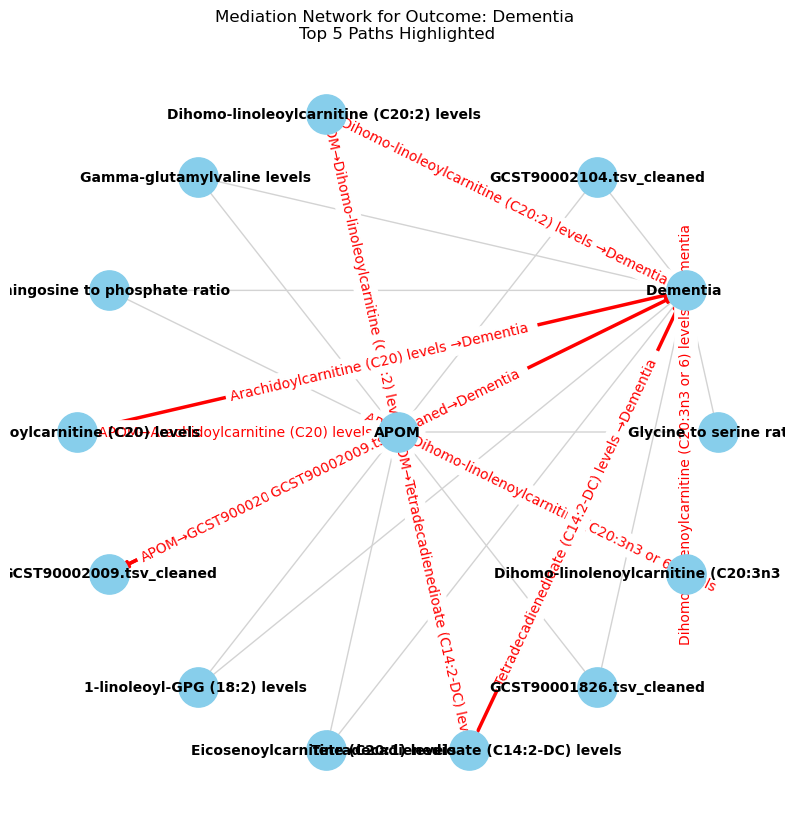

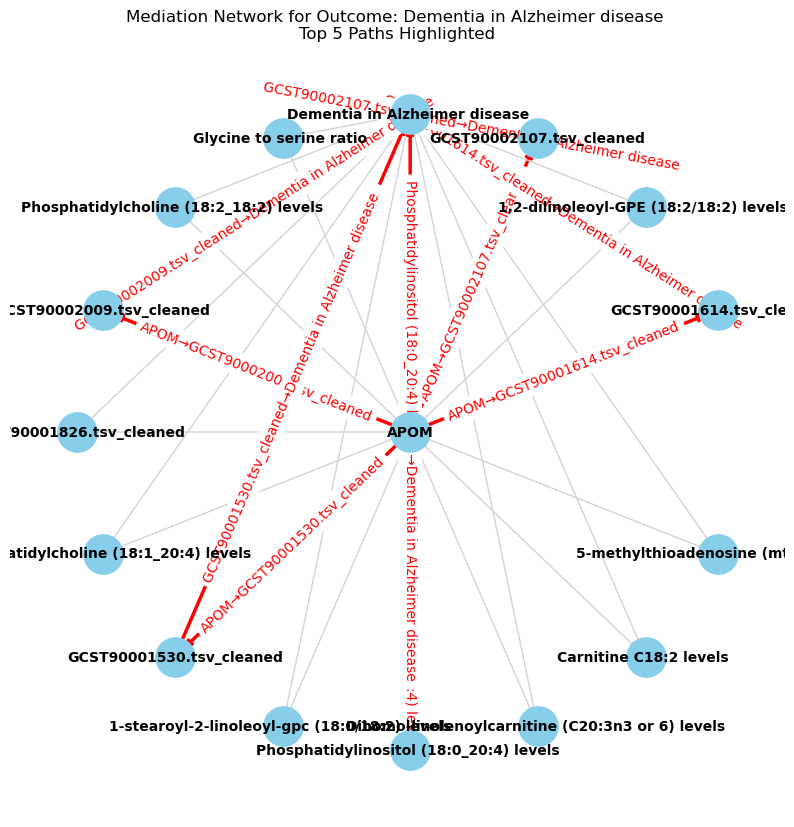

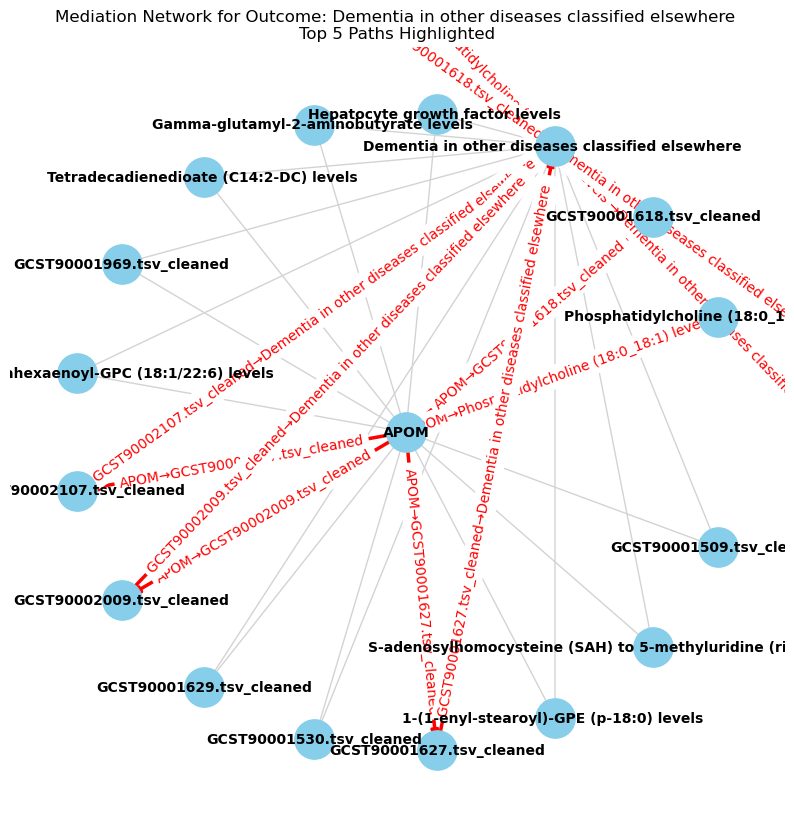

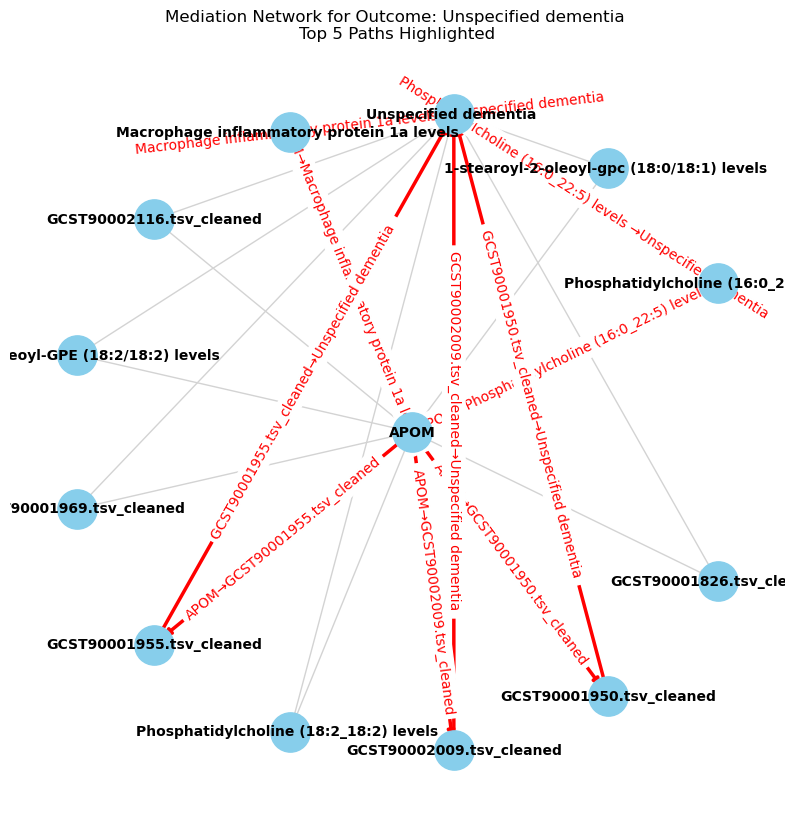

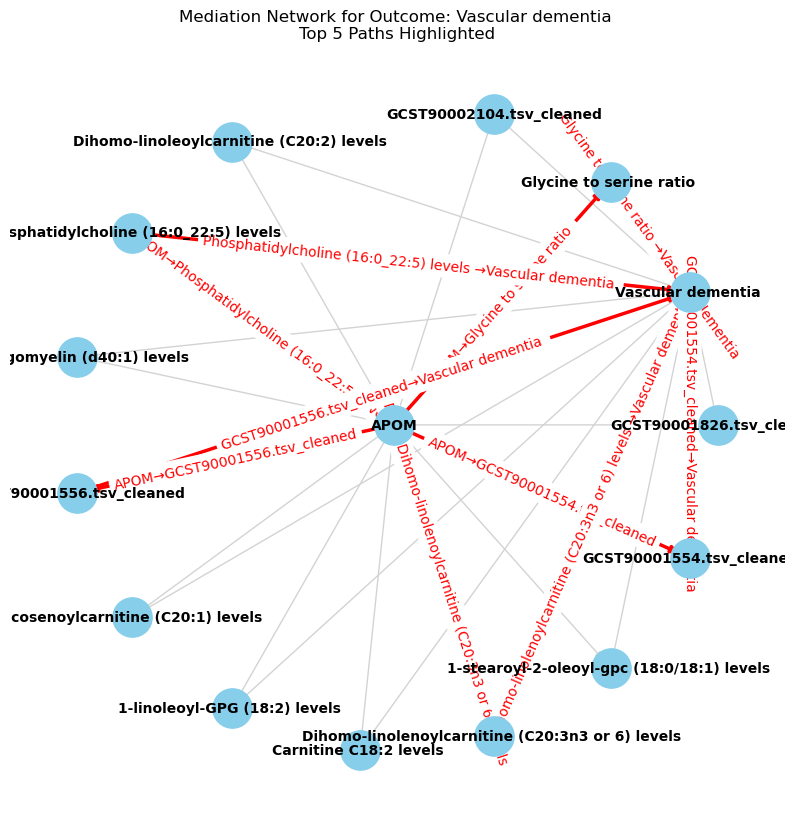

图片已保存至 E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_plots/


In [25]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

# 读取路径贡献数据
df_res = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_paths.csv')
outcomes = df_res['outcome'].unique()

# 创建保存图片的文件夹
output_dir = 'E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_plots/'
os.makedirs(output_dir, exist_ok=True)

# 对每个结局生成网络图
for outcome in outcomes:
    # 筛选当前结局的数据
    df_outcome = df_res[df_res['outcome'] == outcome].copy()
    
    # 提取前五重要路径（按贡献度排序）
    top_paths = df_outcome.nlargest(5, 'contribution')['path'].tolist()
    
    # 创建新的有向图
    G = nx.DiGraph()
    
    # 添加所有节点和边（先用浅灰色）
    all_edges = []
    for path_str in df_outcome['path']:
        path = path_str.split('→')
        for i in range(len(path)-1):
            u, v = path[i], path[i+1]
            all_edges.append((u, v))
    
    # 去重并设置默认样式
    for u, v in set(all_edges):
        G.add_edge(u, v, color='lightgray', width=1.0, label='')
    
    # 高亮前五路径的边
    for path_str in top_paths:
        path = path_str.split('→')
        for i in range(len(path)-1):
            u, v = path[i], path[i+1]
            if G.has_edge(u, v):
                # 设置颜色和标签
                G[u][v]['color'] = 'red'  # 可自定义颜色
                G[u][v]['width'] = 2.5
                G[u][v]['label'] = f"{u}→{v}"  # 显示边标签
    
    # 设置节点位置（环状布局）
    nodes = list(G.nodes())
    pos = nx.circular_layout(G)
    
    # 调整蛋白节点位置（如果需要）
    protein = df_res['path'].iloc[0].split('→')[0]  # 假设第一个路径的起点是蛋白
    if protein in pos:
        pos[protein] = np.array([0, 0])  # 将蛋白节点置于中心
    
    # 绘图
    plt.figure(figsize=(10, 10))
    
    # 绘制所有边（浅灰色）
    edges = G.edges(data=True)
    edge_colors = [e[2]['color'] for e in edges]
    edge_widths = [e[2]['width'] for e in edges]
    edge_labels = { (u, v): e['label'] for u, v, e in edges if e['label'] != '' }
    
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, arrows=True)
    
    # 绘制节点
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # 添加前五路径的边标签
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    # 添加标题
    plt.title(f'Mediation Network for Outcome: {outcome}\nTop 5 Paths Highlighted', fontsize=12)
    plt.axis('off')
    plt.show()
    
    # 保存图片
    plt.savefig(f'{output_dir}/{outcome}_network.png', dpi=300, bbox_inches='tight')
    plt.close()




print(f"图片已保存至 {output_dir}")

In [6]:
import pandas as pd
import networkx as nx

# 读取数据
df_xm = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/APOM_to_mediators.csv')
df_mo = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/mediators_to_outcomes.csv')

try:
    df_xo = pd.read_csv('protein_to_outcomes.csv')
    has_direct = True
except FileNotFoundError:
    has_direct = False

# 构建有向图
G = nx.DiGraph()

# 添加蛋白到中介的边
for _, row in df_xm.iterrows():
    G.add_edge(row['protein'], row['mediator'], weight=row['beta_XM'])

# 添加中介到结局的边
for _, row in df_mo.iterrows():
    G.add_edge(row['mediator'], row['outcome'], weight=row['beta_MO'])

# 添加可选的蛋白到结局的边
if has_direct:
    for _, row in df_xo.iterrows():
        G.add_edge(row['protein'], row['outcome'], weight=row['beta_XO'])

# 获取所有结局
outcomes = sorted({row['outcome'] for _, row in df_mo.iterrows()})
protein = df_xm['protein'].iloc[0]  # 假设只有一个蛋白

results = []
path_details = []

for out in outcomes:
    paths = list(nx.all_simple_paths(G, source=protein, target=out))
    contribs = []
    for path in paths:
        prod = 1.0
        path_betas = []
        for u, v in zip(path, path[1:]):
            prod *= G[u][v]['weight']
            path_betas.append({'from': u, 'to': v, 'beta': G[u][v]['weight']})
        contribs.append((path, prod))
        path_details.append({
            'outcome': out,
            'path': '→'.join(path),
            'contribution': prod,
            'path_betas': path_betas
        })
    
    total_contrib = sum(c for _, c in contribs)
    
    for path, c in contribs:
        prop_of_total = c / total_contrib if total_contrib != 0 else None
        results.append({
            'outcome': out,
            'path': '→'.join(path),
            'contribution': c,
            'total_for_outcome': total_contrib,
            'prop_of_total': prop_of_total
        })

# 保存路径级别贡献
df_res = pd.DataFrame(results)
df_res.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_paths_APOM.csv', index=False)

# 保存路径详细信息
df_path_details = pd.DataFrame(path_details)
df_path_details.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_path_details_APOM.csv', index=False)

# 统计中介贡献
node_records = []
for out in outcomes:
    df_o = df_res[df_res['outcome'] == out]
    total = df_o['total_for_outcome'].iloc[0]
    contrib = {}
    for _, row in df_o.iterrows():
        nodes = row['path'].split('→')[1:-1]
        for m in nodes:
            contrib.setdefault(m, 0.0)
            contrib[m] += row['contribution']
    
    for m, c in contrib.items():
        node_records.append({
            'outcome': out,
            'mediator': m,
            'mediator_total_contrib': c,
            'prop_of_total': c / total if total != 0 else None
        })

df_node = pd.DataFrame(node_records)
df_node.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_mediators_APOM.csv', index=False)

print("Path-level contributions saved to network_mr_paths.csv")
print("Path details saved to network_mr_path_details.csv")
print("Mediator-level contributions saved to network_mr_mediators.csv")

Path-level contributions saved to network_mr_paths.csv
Path details saved to network_mr_path_details.csv
Mediator-level contributions saved to network_mr_mediators.csv


In [8]:
import pandas as pd
import networkx as nx

# 读取数据
df_xm = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/CD276_to_mediators.csv')
df_mo = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/mediators_to_outcomes.csv')

try:
    df_xo = pd.read_csv('protein_to_outcomes.csv')
    has_direct = True
except FileNotFoundError:
    has_direct = False

# 构建有向图
G = nx.DiGraph()

# 添加蛋白到中介的边
for _, row in df_xm.iterrows():
    G.add_edge(row['protein'], row['mediator'], weight=row['beta_XM'])

# 添加中介到结局的边
for _, row in df_mo.iterrows():
    G.add_edge(row['mediator'], row['outcome'], weight=row['beta_MO'])

# 添加可选的蛋白到结局的边
if has_direct:
    for _, row in df_xo.iterrows():
        G.add_edge(row['protein'], row['outcome'], weight=row['beta_XO'])

# 获取所有结局（去重并排序）
outcomes = sorted(df_mo['outcome'].unique())
protein = df_xm['protein'].iloc[0]  # 假设只有一个蛋白

results = []
path_details = []

# --- 计算路径贡献（修复空路径问题）---
for out in outcomes:
    try:
        paths = list(nx.all_simple_paths(G, source=protein, target=out))
    except nx.NetworkXNoPath:
        paths = []  # 处理没有路径的情况

    contribs = []
    for path in paths:
        prod = 1.0
        path_betas = []
        for u, v in zip(path, path[1:]):
            prod *= G[u][v]['weight']
            path_betas.append({'from': u, 'to': v, 'beta': G[u][v]['weight']})
        contribs.append((path, prod))
        path_details.append({
            'outcome': out,
            'path': '→'.join(path),
            'contribution': prod,
            'path_betas': path_betas
        })

    # 处理无路径的情况
    if len(contribs) == 0:
        total_contrib = 0.0
        results.append({
            'outcome': out,
            'path': None,
            'contribution': 0.0,
            'total_for_outcome': 0.0,
            'prop_of_total': None
        })
    else:
        total_contrib = sum(c for _, c in contribs)
        for path, c in contribs:
            prop_of_total = c / total_contrib if total_contrib != 0 else None
            results.append({
                'outcome': out,
                'path': '→'.join(path),
                'contribution': c,
                'total_for_outcome': total_contrib,
                'prop_of_total': prop_of_total
            })

# --- 保存路径贡献 ---
df_res = pd.DataFrame(results)
df_res.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_paths_CD276.csv', index=False)

# --- 保存路径详细信息（优化Beta值展示）---
# 将Beta值拆分为多列（例如：step1_beta, step2_beta）
def expand_path_betas(row):
    betas = row['path_betas']
    for i, beta_info in enumerate(betas, start=1):
        row[f'step{i}_from'] = beta_info['from']
        row[f'step{i}_to'] = beta_info['to']
        row[f'step{i}_beta'] = beta_info['beta']
    return row

df_path_details = pd.DataFrame(path_details)
if not df_path_details.empty:
    df_path_details = df_path_details.apply(expand_path_betas, axis=1)
    df_path_details.drop(columns=['path_betas'], inplace=True)
df_path_details.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_path_details_CD276.csv', index=False)

# --- 统计中介贡献（修复空DataFrame问题）---
node_records = []
valid_outcomes = df_res['outcome'].unique()  # 只处理有记录的outcome

for out in valid_outcomes:
    df_o = df_res[df_res['outcome'] == out]
    if df_o.empty:
        continue  # 跳过空记录
    total = df_o['total_for_outcome'].iloc[0]
    contrib = {}
    for _, row in df_o.iterrows():
        if row['path'] is None:
            continue  # 跳过无路径的情况
        nodes = row['path'].split('→')[1:-1]
        for m in nodes:
            contrib[m] = contrib.get(m, 0.0) + row['contribution']
    for m, c in contrib.items():
        node_records.append({
            'outcome': out,
            'mediator': m,
            'mediator_total_contrib': c,
            'prop_of_total': c / total if total != 0 else None
        })

df_node = pd.DataFrame(node_records)
df_node.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_mediators_CD276.csv', index=False)

print("数据已保存")

数据已保存


In [7]:
import pandas as pd
import networkx as nx

# 读取数据
df_xm = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/EGFR_to_mediators.csv')
df_mo = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/mediators_to_outcomes.csv')

try:
    df_xo = pd.read_csv('protein_to_outcomes.csv')
    has_direct = True
except FileNotFoundError:
    has_direct = False

# 构建有向图
G = nx.DiGraph()

# 添加蛋白到中介的边
for _, row in df_xm.iterrows():
    G.add_edge(row['protein'], row['mediator'], weight=row['beta_XM'])

# 添加中介到结局的边
for _, row in df_mo.iterrows():
    G.add_edge(row['mediator'], row['outcome'], weight=row['beta_MO'])

# 添加可选的蛋白到结局的边
if has_direct:
    for _, row in df_xo.iterrows():
        G.add_edge(row['protein'], row['outcome'], weight=row['beta_XO'])

# 获取所有结局（去重并排序）
outcomes = sorted(df_mo['outcome'].unique())
protein = df_xm['protein'].iloc[0]  # 假设只有一个蛋白

results = []
path_details = []

# --- 计算路径贡献（修复空路径问题）---
for out in outcomes:
    try:
        paths = list(nx.all_simple_paths(G, source=protein, target=out))
    except nx.NetworkXNoPath:
        paths = []  # 处理没有路径的情况

    contribs = []
    for path in paths:
        prod = 1.0
        path_betas = []
        for u, v in zip(path, path[1:]):
            prod *= G[u][v]['weight']
            path_betas.append({'from': u, 'to': v, 'beta': G[u][v]['weight']})
        contribs.append((path, prod))
        path_details.append({
            'outcome': out,
            'path': '→'.join(path),
            'contribution': prod,
            'path_betas': path_betas
        })

    # 处理无路径的情况
    if len(contribs) == 0:
        total_contrib = 0.0
        results.append({
            'outcome': out,
            'path': None,
            'contribution': 0.0,
            'total_for_outcome': 0.0,
            'prop_of_total': None
        })
    else:
        total_contrib = sum(c for _, c in contribs)
        for path, c in contribs:
            prop_of_total = c / total_contrib if total_contrib != 0 else None
            results.append({
                'outcome': out,
                'path': '→'.join(path),
                'contribution': c,
                'total_for_outcome': total_contrib,
                'prop_of_total': prop_of_total
            })

# --- 保存路径贡献 ---
df_res = pd.DataFrame(results)
df_res.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_paths_EGFR.csv', index=False)

# --- 保存路径详细信息（优化Beta值展示）---
# 将Beta值拆分为多列（例如：step1_beta, step2_beta）
def expand_path_betas(row):
    betas = row['path_betas']
    for i, beta_info in enumerate(betas, start=1):
        row[f'step{i}_from'] = beta_info['from']
        row[f'step{i}_to'] = beta_info['to']
        row[f'step{i}_beta'] = beta_info['beta']
    return row

df_path_details = pd.DataFrame(path_details)
if not df_path_details.empty:
    df_path_details = df_path_details.apply(expand_path_betas, axis=1)
    df_path_details.drop(columns=['path_betas'], inplace=True)
df_path_details.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_path_details_EGFR.csv', index=False)

# --- 统计中介贡献（修复空DataFrame问题）---
node_records = []
valid_outcomes = df_res['outcome'].unique()  # 只处理有记录的outcome

for out in valid_outcomes:
    df_o = df_res[df_res['outcome'] == out]
    if df_o.empty:
        continue  # 跳过空记录
    total = df_o['total_for_outcome'].iloc[0]
    contrib = {}
    for _, row in df_o.iterrows():
        if row['path'] is None:
            continue  # 跳过无路径的情况
        nodes = row['path'].split('→')[1:-1]
        for m in nodes:
            contrib[m] = contrib.get(m, 0.0) + row['contribution']
    for m, c in contrib.items():
        node_records.append({
            'outcome': out,
            'mediator': m,
            'mediator_total_contrib': c,
            'prop_of_total': c / total if total != 0 else None
        })

df_node = pd.DataFrame(node_records)
df_node.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_mediators_EGFR.csv', index=False)

print("数据已保存")

数据已保存


In [9]:
import pandas as pd
import networkx as nx

# 读取数据
df_xm = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/GDF15_to_mediators.csv')
df_mo = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/mediators_to_outcomes.csv')

try:
    df_xo = pd.read_csv('protein_to_outcomes.csv')
    has_direct = True
except FileNotFoundError:
    has_direct = False

# 构建有向图
G = nx.DiGraph()

# 添加蛋白到中介的边
for _, row in df_xm.iterrows():
    G.add_edge(row['protein'], row['mediator'], weight=row['beta_XM'])

# 添加中介到结局的边
for _, row in df_mo.iterrows():
    G.add_edge(row['mediator'], row['outcome'], weight=row['beta_MO'])

# 添加可选的蛋白到结局的边
if has_direct:
    for _, row in df_xo.iterrows():
        G.add_edge(row['protein'], row['outcome'], weight=row['beta_XO'])

# 获取所有结局（去重并排序）
outcomes = sorted(df_mo['outcome'].unique())
protein = df_xm['protein'].iloc[0]  # 假设只有一个蛋白

results = []
path_details = []

# --- 计算路径贡献（修复空路径问题）---
for out in outcomes:
    try:
        paths = list(nx.all_simple_paths(G, source=protein, target=out))
    except nx.NetworkXNoPath:
        paths = []  # 处理没有路径的情况

    contribs = []
    for path in paths:
        prod = 1.0
        path_betas = []
        for u, v in zip(path, path[1:]):
            prod *= G[u][v]['weight']
            path_betas.append({'from': u, 'to': v, 'beta': G[u][v]['weight']})
        contribs.append((path, prod))
        path_details.append({
            'outcome': out,
            'path': '→'.join(path),
            'contribution': prod,
            'path_betas': path_betas
        })

    # 处理无路径的情况
    if len(contribs) == 0:
        total_contrib = 0.0
        results.append({
            'outcome': out,
            'path': None,
            'contribution': 0.0,
            'total_for_outcome': 0.0,
            'prop_of_total': None
        })
    else:
        total_contrib = sum(c for _, c in contribs)
        for path, c in contribs:
            prop_of_total = c / total_contrib if total_contrib != 0 else None
            results.append({
                'outcome': out,
                'path': '→'.join(path),
                'contribution': c,
                'total_for_outcome': total_contrib,
                'prop_of_total': prop_of_total
            })

# --- 保存路径贡献 ---
df_res = pd.DataFrame(results)
df_res.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_paths_GDF15.csv', index=False)

# --- 保存路径详细信息（优化Beta值展示）---
# 将Beta值拆分为多列（例如：step1_beta, step2_beta）
def expand_path_betas(row):
    betas = row['path_betas']
    for i, beta_info in enumerate(betas, start=1):
        row[f'step{i}_from'] = beta_info['from']
        row[f'step{i}_to'] = beta_info['to']
        row[f'step{i}_beta'] = beta_info['beta']
    return row

df_path_details = pd.DataFrame(path_details)
if not df_path_details.empty:
    df_path_details = df_path_details.apply(expand_path_betas, axis=1)
    df_path_details.drop(columns=['path_betas'], inplace=True)
df_path_details.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_path_details_GDF15.csv', index=False)

# --- 统计中介贡献（修复空DataFrame问题）---
node_records = []
valid_outcomes = df_res['outcome'].unique()  # 只处理有记录的outcome

for out in valid_outcomes:
    df_o = df_res[df_res['outcome'] == out]
    if df_o.empty:
        continue  # 跳过空记录
    total = df_o['total_for_outcome'].iloc[0]
    contrib = {}
    for _, row in df_o.iterrows():
        if row['path'] is None:
            continue  # 跳过无路径的情况
        nodes = row['path'].split('→')[1:-1]
        for m in nodes:
            contrib[m] = contrib.get(m, 0.0) + row['contribution']
    for m, c in contrib.items():
        node_records.append({
            'outcome': out,
            'mediator': m,
            'mediator_total_contrib': c,
            'prop_of_total': c / total if total != 0 else None
        })

df_node = pd.DataFrame(node_records)
df_node.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_mediators_GDF15.csv', index=False)

print("数据已保存")

数据已保存


In [10]:
import pandas as pd
import networkx as nx

# 读取数据
df_xm = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/GHRL_to_mediators.csv')
df_mo = pd.read_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/mediators_to_outcomes.csv')

try:
    df_xo = pd.read_csv('protein_to_outcomes.csv')
    has_direct = True
except FileNotFoundError:
    has_direct = False

# 构建有向图
G = nx.DiGraph()

# 添加蛋白到中介的边
for _, row in df_xm.iterrows():
    G.add_edge(row['protein'], row['mediator'], weight=row['beta_XM'])

# 添加中介到结局的边
for _, row in df_mo.iterrows():
    G.add_edge(row['mediator'], row['outcome'], weight=row['beta_MO'])

# 添加可选的蛋白到结局的边
if has_direct:
    for _, row in df_xo.iterrows():
        G.add_edge(row['protein'], row['outcome'], weight=row['beta_XO'])

# 获取所有结局（去重并排序）
outcomes = sorted(df_mo['outcome'].unique())
protein = df_xm['protein'].iloc[0]  # 假设只有一个蛋白

results = []
path_details = []

# --- 计算路径贡献（修复空路径问题）---
for out in outcomes:
    try:
        paths = list(nx.all_simple_paths(G, source=protein, target=out))
    except nx.NetworkXNoPath:
        paths = []  # 处理没有路径的情况

    contribs = []
    for path in paths:
        prod = 1.0
        path_betas = []
        for u, v in zip(path, path[1:]):
            prod *= G[u][v]['weight']
            path_betas.append({'from': u, 'to': v, 'beta': G[u][v]['weight']})
        contribs.append((path, prod))
        path_details.append({
            'outcome': out,
            'path': '→'.join(path),
            'contribution': prod,
            'path_betas': path_betas
        })

    # 处理无路径的情况
    if len(contribs) == 0:
        total_contrib = 0.0
        results.append({
            'outcome': out,
            'path': None,
            'contribution': 0.0,
            'total_for_outcome': 0.0,
            'prop_of_total': None
        })
    else:
        total_contrib = sum(c for _, c in contribs)
        for path, c in contribs:
            prop_of_total = c / total_contrib if total_contrib != 0 else None
            results.append({
                'outcome': out,
                'path': '→'.join(path),
                'contribution': c,
                'total_for_outcome': total_contrib,
                'prop_of_total': prop_of_total
            })

# --- 保存路径贡献 ---
df_res = pd.DataFrame(results)
df_res.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_paths_GHRL.csv', index=False)

# --- 保存路径详细信息（优化Beta值展示）---
# 将Beta值拆分为多列（例如：step1_beta, step2_beta）
def expand_path_betas(row):
    betas = row['path_betas']
    for i, beta_info in enumerate(betas, start=1):
        row[f'step{i}_from'] = beta_info['from']
        row[f'step{i}_to'] = beta_info['to']
        row[f'step{i}_beta'] = beta_info['beta']
    return row

df_path_details = pd.DataFrame(path_details)
if not df_path_details.empty:
    df_path_details = df_path_details.apply(expand_path_betas, axis=1)
    df_path_details.drop(columns=['path_betas'], inplace=True)
df_path_details.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_path_details_GHRL.csv', index=False)

# --- 统计中介贡献（修复空DataFrame问题）---
node_records = []
valid_outcomes = df_res['outcome'].unique()  # 只处理有记录的outcome

for out in valid_outcomes:
    df_o = df_res[df_res['outcome'] == out]
    if df_o.empty:
        continue  # 跳过空记录
    total = df_o['total_for_outcome'].iloc[0]
    contrib = {}
    for _, row in df_o.iterrows():
        if row['path'] is None:
            continue  # 跳过无路径的情况
        nodes = row['path'].split('→')[1:-1]
        for m in nodes:
            contrib[m] = contrib.get(m, 0.0) + row['contribution']
    for m, c in contrib.items():
        node_records.append({
            'outcome': out,
            'mediator': m,
            'mediator_total_contrib': c,
            'prop_of_total': c / total if total != 0 else None
        })

df_node = pd.DataFrame(node_records)
df_node.to_csv('E:/neuro_od/T2D-痴呆结果/Dementia_中介分析/network_mr_mediators_GHRL.csv', index=False)

print("数据已保存")

数据已保存


数据已保存
